In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

fashion_mnist dataset내려받기

In [5]:
train_dataset = torchvision.datasets.FashionMNIST('./', download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST('./', download=True,
                                                  train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



fashion_mnist 데이터를 데이터로더에 전달

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

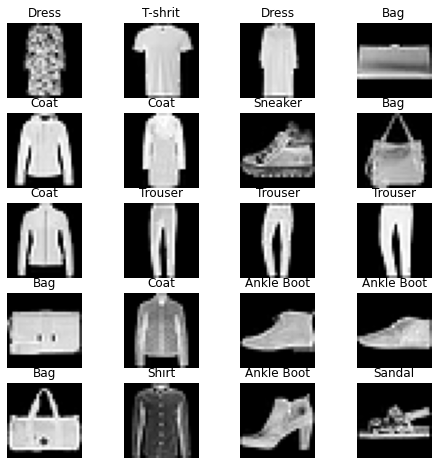

In [7]:
# 분류에 사용될 클래스 정의
labels_map = {0: 'T-shrit', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',
              6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns=4
rows=5

for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()

심층 신경망 모델 생성

In [8]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

심층 신경망에서 필요한 파라미터 정의

In [9]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


심층 신경망을 이용한 모델 학습

In [11]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.5672764778137207, Accuracy: 83.36000061035156%
Iteration: 1000, Loss: 0.48392176628112793, Accuracy: 84.04000091552734%
Iteration: 1500, Loss: 0.3953094184398651, Accuracy: 84.12999725341797%
Iteration: 2000, Loss: 0.437595397233963, Accuracy: 85.25%
Iteration: 2500, Loss: 0.28457844257354736, Accuracy: 86.23999786376953%
Iteration: 3000, Loss: 0.3108667731285095, Accuracy: 86.20999908447266%


합성곱 네트워크 생성

In [12]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.drop(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [14]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print('Iteration: {}, Loss: {}, Accuracy: {}%'.format(count, loss.data, accuracy))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4417397677898407, Accuracy: 87.69999694824219%
Iteration: 1000, Loss: 0.3507411479949951, Accuracy: 88.08999633789062%
Iteration: 1500, Loss: 0.33885276317596436, Accuracy: 87.00999450683594%
Iteration: 2000, Loss: 0.23382356762886047, Accuracy: 89.12999725341797%
Iteration: 2500, Loss: 0.14370259642601013, Accuracy: 89.80999755859375%
Iteration: 3000, Loss: 0.17016255855560303, Accuracy: 90.1199951171875%
